In [1]:
//===========Program to plot TDC and ADC data from root trees by Davison, Hesse, Losasda, Kerver, Porter, Bonilla, Horn, Thompson, Watkins, Brash==========
#include <iostream>
#include <fstream>
#include "TFile.h"
#include "TTree.h"
#include "TF1.h"
#include "TH1.h"
#include "TSystem.h"
#include "TMath.h"
#include "TRandom.h"
#include "TH2.h"
#include "TCanvas.h"
#include "TGraph.h"
#include "TStyle.h"
#include "TProfile.h"

//Global Variables
bool remakepedfile= false;
const int bin = 100; 
const Int_t Nadc = 16;
const Int_t Ntdc = 16;
const Int_t pedrun = 172;
const Int_t bl=Ntdc-16+0;//Start at channel 0
const Int_t br=Ntdc-16+1;
const Int_t tl=Ntdc-16+2;
const Int_t tr=Ntdc-16+3;
const Double_t adjadcto=1400.0;//value to ADJust ADC TO
Double_t t_fullscale = 140.0E-09; // full scale TDC range in seconds
Double_t t_convert=t_fullscale/4096.0;

const Int_t nthetabins = 51;
const Double_t thetalow = -100.5;
const Double_t thetahigh = 100.5;

In [2]:
void luterplots(Int_t nrun, Double_t nscint=1.50) {

        Double_t vn = 2.997E08/nscint;
	Double_t resolution = 0.0232*nscint*nscint-0.1061*nscint+0.1617;
        resolution = resolution*0.934;
        cout << "Resolution = " << resolution << endl;
        Double_t granularity = t_convert*vn/2.0;
        Double_t xpos_range = 0.30;
        Double_t dscint = 0.105; // distance between scintillators in metres
        const int xposbin = 2.0*xpos_range/granularity;

	TRandom r;
	Double_t rnd;

//create new pedestal values


	Char_t tdcnames[][Ntdc]={"Bottom Left","Bottom Right","Top Left","Top Right","4","5","6","7","8","9","10","11","12","13","14","15"};	
	Char_t adcnames[][Nadc]={"Bottom Left","Bottom Right","Top Left","Top Right","4","5","6","7","8","9","10","11","12","13","14","15"};


//Set correction values
    Double_t tdccorrect[Ntdc];
    Double_t ped[Nadc];
    Double_t gain[Nadc];

	
//Read files and tree branches 
	gStyle->SetOptStat(1);
	TFile *froot =  new TFile(Form("./rootfiles/test%d.root",nrun));
	TTree *troot = (TTree*)froot->Get("tdata");
	Int_t tdc[Ntdc]; 
	Int_t adc[Nadc]; 
	troot->SetBranchAddress("tdc",&tdc);
	troot->SetBranchAddress("adc",&adc);
	const int nevents_in_file = (int)troot->GetEntries();

        cout << "Opened rootfile and read in " << nevents_in_file << " events." << endl;

//Create Histograms
	TH1F *htdcraw[Ntdc], *htdcadjusted[Ntdc], *hadcraw[Nadc], *hadccut[Nadc], *hadcadjusted[Nadc];
	TH1F *htpos = new TH1F("htpos","Top Position",xposbin,-1.0*xpos_range,xpos_range); //Histogram for top scintillator
	TH1F *hbpos = new TH1F("hbpos","Bottom Position",xposbin,-1.0*xpos_range,xpos_range); //Histogram for bottom scintillator 
	//htheta = new TH1F("htheta","Angle (Degrees)",10*bin,-100.5,100.5); //Histogram for incidence angle
	TH1F *htheta = new TH1F("htheta","Angle (Degrees)",nthetabins,thetalow,thetahigh); //Histogram for incidence angle
	TH1F *hmeantime = new TH1F("hmeantime","Mean Position (m)",100,-0.5,0.5); //Histogram for mean top/bottom time
	TH1F *htheta2 = new TH1F("htheta2","Angle (Degrees)",nthetabins,thetalow,thetahigh); //Histogram for simulated incidence angle
	TH1F *hadctop = new TH1F("hadctop","Top Energy Dep",bin,0,8500);
	TH1F *hadcbot = new TH1F("hadcbot","Bottom Energy Dep",bin,0,8500);

	TH1F *ovhadctop = new TH1F("ovhadctop", "Energy Deposits (Top: red, Bottom: blue)", bin, 0, 8500);
	TH1F *ovhadcbot = new TH1F("ovhadcbot", "Energy Deposits", bin, 0, 8500);

	TH1F *hadcoverlay = new TH1F("hadcoverlay","Top vs Bottom",bin,0,3);
    TH2F *htopLeftvXpos = new TH2F("htopLeftvXpos","corrected top left paddle ADC vs. xpos top ",100,-0.30,0.30,50,0,2500);
    TH2F *htopRightvXpos = new TH2F("htopRightvXpos","corrected top right paddle ADC vs. xpos top ",100,-0.30,0.30,50,0,2500);
    TH2F *hbotLeftvXpos = new TH2F("hbotLeftvXpos","corrected bottom left paddle ADC vs. xpos bottom ",100,-0.30,0.30,50,0,2500);
    TH2F *hbotRightvXpos = new TH2F("hbotRightvXpos","corrected bottom right paddle ADC vs. xpos bottom ",100,-0.30,0.30,50,0,2500);
    TH2F *htopadctheta = new TH2F("htopadctheta","corrected top ADC vs. theta ",1000,-60.0,60.0,200,0,4500);
    TH2F *hbotadctheta = new TH2F("hbotadctheta","corrected bottom ADC vs. theta ",1000,-60.0,60.0,200,0,4500);

    TH2F *httlxtop = new TH2F("httlxtop","Corrected Top Left Time vs. xtop",100,-0.30,0.30,100,1900,2100);
    TH2F *htblxtop = new TH2F("htblxtop","Corrected Bottom Left Time vs. xtop",100,-0.30,0.30,100,1900,2100);
    TH2F *htbrxtop = new TH2F("htbrxtop","Corrected Bottom Right Time vs. xtop",100,-0.30,0.30,100,1900,2100);
    TH2F *httlxbot = new TH2F("httlxbot","Corrected Top Left Time vs. xbottom",100,-0.30,0.30,100,1900,2100);
    TH2F *htblxbot = new TH2F("htblxbot","Corrected Bottom Left Time vs. xbottom",100,-0.30,0.30,100,1900,2100);
    TH2F *htbrxbot = new TH2F("htbrxbot","Corrected Bottom Right Time vs. xbottom",100,-0.30,0.30,100,1900,2100);

    cout << "Defined first set of histograms ... " << endl;

	for ( int i = 0; i < Ntdc ; i++) {
		htdcraw[i] = new TH1F(Form("htdcraw%02d", i),Form("%s   raw tdc",tdcnames[i]),bin,1700,2100);
        	htdcadjusted[i] = new TH1F(Form("htdcadjusted%02d", i),Form("%s   adjusted tdc",tdcnames[i]),bin,1500,2500);
	}
    
	for ( int i = 0; i < Nadc ; i++) {
        	hadcraw[i] = new TH1F(Form("hadcraw%02d", i),Form("%s   raw adc",adcnames[i]),bin,0,5500);
        	hadccut[i] = new TH1F(Form("hadccut%02d", i),Form("%s  cut adc",adcnames[i]),bin,0,5500);
        	hadcadjusted[i] = new TH1F(Form("hadcadjusted%02d", i),Form("%s   adjusted adc",adcnames[i]),bin,0,5500);
        }
    
    cout << "Defined second set of histograms ... " << endl;
	
//=====================================GET PED for ADC==========================
	if(remakepedfile){cout << "Executing luterpedestals.C" << endl; gROOT->ProcessLine(Form(".x luterpedestals.C(%d)",pedrun));cout<<"pedestal file made"<<endl;}
	cout << "Opening pedestal values file ... " << endl;
        FILE *adcpeds = fopen(Form("./pedestalfiles/pedestalrun%d.dat",pedrun),"r");
	cout << "Filling ADC pedestal array ..." << endl;
        for( int i = 0; i < Nadc ; i++) {//Start ADC filling loop
		fscanf(adcpeds,"%lf\n",&ped[i]);
		//printf("%lf\n",ped[i]);
	}

        cout << "Read in pedestal file ... " << endl;

//=====================================GET ADJ FACTORS for ADC&TDC==========================
    cout << "Starting adc and tdc calibration loop ... " << endl;

    //for (int ie = 0; ie < nevents_in_file; ie++) {
    for (int ie = 0; ie < 10000; ie++) {
		troot->GetEntry(ie);
		if(ie%1000==0.0&&ie!=0){cout<<"Progress: "<<((double)ie)/((double)nevents_in_file)*100<<"%"<<endl;
		}
		for( int i = 0; i < Ntdc ; i++) {//Start TDC filling loop
                       if(adc[i] < 3600){
            		htdcraw[i]->Fill(tdc[i]);
                        }
		}
		for( int i = 0; i < Nadc ; i++) {//Start ADC-ADJUSTED filling loop
                     if (adc[i] < 3600){
			hadcraw[i]->Fill(adc[i]);
 			hadccut[i]->Fill(adc[i]-ped[i]);
                      }
		}//End ADC for loop
	}

	TCanvas *c1 = new TCanvas("c1","tdc raw fitter",75,75,600,600);
   	c1->Divide(2,2);
   	for ( int i = bl; i <= tr ; i++) {
      	c1->cd(i-bl+1);		
		htdcraw[i]->Draw();
//the next 7 lines allow us to automatically set the fitting range
		int highbin=5;		
		for(int ii=0;ii<=bin;ii++){
			if((htdcraw[i]->GetBinContent(ii))>(htdcraw[i]->GetBinContent(highbin))&&ii>=5){
				highbin=ii;
			}
		}
		int median = htdcraw[i]->GetBinCenter(highbin);
		htdcraw[i]->Fit("gaus","Q","",(median-200),(median+200));
		tdccorrect[i] = 2000 - (htdcraw[i]->GetFunction("gaus")->GetParameter(1));
    }
	//c1->Close(); //closes default canvas built within histo_>Fit



//==============LOOP THROUGH EVENTS IN FILE AND DO MATHS=============================

    //for (int ie = 0; ie < nevents_in_file; ie++) {
    for (int ie = 0; ie < 10000; ie++) {
		troot->GetEntry(ie);  
	//=========================================ADC===============================
        if(ie%1000==0.0&&ie!=0){cout<<"Progress: "<<((double)ie)/((double)nevents_in_file)*100<<"%"<<endl;
	}
		for( int i = 0; i < Nadc ; i++) {//Start ADC-ADJUSTED filling loop
			
				gain[i]=adjadcto/(hadccut[i]->GetMean());
				if(gain[i]*(adc[i]-ped[i])<4000){	 
			        hadcadjusted[i]->Fill(gain[i]*(adc[i]-ped[i]));
				}
			
		}//End ADC for loop
		    
		    	Double_t ebl = gain[bl]*(adc[bl]-ped[bl]);
		    	Double_t ebr = gain[br]*(adc[br]-ped[br]);
		    	Double_t etl = gain[tl]*(adc[tl]-ped[tl]);
		    	Double_t etr = gain[tr]*(adc[tr]-ped[tr]);
		
	//==========================================TDC===============================
		    
			for( int i = 0; i < Ntdc ; i++) {//Start TDC filling loop
				if(i<4){
					htdcadjusted[i]->Fill(tdc[i]+tdccorrect[i]);		
				}
				else{	
					htdcadjusted[i]->Fill(tdc[i]);
				}
			}//End TDC for loop

                        Bool_t good_bl = (abs(tdc[bl]+tdccorrect[bl]-2000)<50.0);
                        Bool_t good_br = (abs(tdc[br]+tdccorrect[br]-2000)<50.0);
                        Bool_t good_tl = (abs(tdc[tl]+tdccorrect[tl]-2000)<50.0);
                        Bool_t good_tr = (abs(tdc[tr]+tdccorrect[tr]-2000)<50.0);
                        Bool_t good_event = good_bl&&good_br&&good_tl&&good_tr;

		    if (good_event){
                        Double_t tbl = tdc[bl]+tdccorrect[bl];
			Double_t tbr = tdc[br]+tdccorrect[br];
			Double_t ttl = tdc[tl]+tdccorrect[tl];
			Double_t ttr = tdc[tr]+tdccorrect[tr];
			Double_t rtod = 180.0/3.14159265;
			Double_t tdiff = (ttl-ttr)/2.0;
			Double_t bdiff = (tbl-tbr)/2.0;
		        Double_t xmeantime = ((ttl+ttr)/2.0-(tbl+tbr)/2.0)*t_convert*vn;	
			Double_t xtop = tdiff*t_convert*vn;
			Double_t xbottom = bdiff*t_convert*vn;
			rnd = r.Gaus(0.0,1.5);
			Double_t rnd_top_pos = r.Gaus(0.0,resolution);
			Double_t rnd_bottom_pos = r.Gaus(0.0,resolution);
                        
			//New simulation method
			TF1 *fphi = new TF1("fsin", "x", 0, 2*TMath::Pi());
                        TF1 *fcos = new TF1("fcos", "cos(x)*cos(x)",-TMath::Pi()/2.0,TMath::Pi()/2.0);
                        Double_t phisim, cossim, rndxt, rndyt, rndrt, rndrr, rndxb, rndyb;
                        while (true) {
                            phisim = fphi->GetRandom();
                            cossim = fcos->GetRandom();
                            rndxt = r.Uniform(-0.10,0.10);
                            rndyt = r.Uniform(-0.15,0.15);
                            rndrt = sqrt(rndxt*rndxt+rndyt*rndyt)+rnd_top_pos;
                            rndrr = dscint*tan(cossim);
                            rndxb = rndxt+rndrr*cos(phisim);
                            rndyb = rndyt+rndrr*sin(phisim);
                            if (rndxb > -0.10 && rndxb < 0.10 && rndyb > -0.15 && rndyb < 0.15) break;
                        }

                        Double_t rndrb = sqrt(rndxb*rndxb+rndyb*rndyb)+rnd_bottom_pos;
			Double_t theta = rtod*atan((xbottom-xtop)/dscint)+rnd;
                        //adjust for slight angular offset
                        Double_t theta2 = 0.8281-rtod*atan((rndrt-rndrb)/dscint);

			if(xtop > -0.4 && xtop < 0.4 && xbottom > -0.4 && xbottom < 0.4) {
			        httlxtop->Fill(xtop,ttl);
			        htblxtop->Fill(xtop,tbl);
			        htbrxtop->Fill(xtop,tbr);
			        httlxbot->Fill(xbottom,ttl);
			        htblxbot->Fill(xbottom,tbl);
			        htbrxbot->Fill(xbottom,tbr);
                                htpos->Fill(xtop);
				hbpos->Fill(xbottom);
		    		if(abs(theta)<=85.0) htheta->Fill(theta);
		    		if(abs(theta2)<=85.0) htheta2->Fill(theta2);
			}

			htopLeftvXpos->Fill(xtop,etl); 
			htopRightvXpos->Fill(xtop,etr); 
			hbotLeftvXpos->Fill(xbottom,ebl); 
			hbotRightvXpos->Fill(xbottom,ebr); 
		    
			htopadctheta->Fill(theta,(etl+etr)/2.0); 
			hbotadctheta->Fill(theta,(ebl+ebr)/2.0); 
			hadctop->Fill((etl+etr)/2.0); 
			hadcbot->Fill((ebl+ebr)/2.0); 

			ovhadctop->Fill((etl+etr)/2.0);
			ovhadcbot->Fill((ebl+ebr)/2.0);			

			hadcoverlay->Fill((etl+etr)/(ebl+ebr));
			hmeantime->Fill(xmeantime);
                    }

	} //End of loop over events
	
    
//=======================================Canvases=============================

//Draw TDC and ADC raw data
    
 	TCanvas *tdc_canvas = new TCanvas("tdc_canvas","Raw ADC spectra",100,100,600,600);
   	tdc_canvas->Divide(2,2);
   	for ( int i = bl; i <= tr ; i++) {
      			tdc_canvas->cd(i-bl+1);
				hadcraw[i]->Draw();
				//hadccut[i]->Draw();
      			//htdcadjusted[i]->Draw();
	}
 	TCanvas *tdca_canvas = new TCanvas("tdca_canvas","Adjusted TDC spectra",112,112,600,600);
   	tdca_canvas->Divide(2,2);
   	for ( int i = bl; i <= tr ; i++) {
      			tdca_canvas->cd(i-bl+1);
				//hadcraw[i]->Draw();
				//hadccut[i]->Draw();
      			htdcadjusted[i]->Draw();
	}


        TCanvas *adc_canvas = new TCanvas("adc_canvas","Corrected ADC spectra",125,125,600,600);
        adc_canvas->Divide(2,2);
        for ( int i = 0; i <= 3 ; i++) {
                		adc_canvas->cd(i+1);
				//hadcraw[i]->Draw();
				//hadccut[i]->Draw();                
				hadcadjusted[i]->Draw();
        }

 	TCanvas *adcpos = new TCanvas("adcpos","ADC vs xpos",150,150,600,600);
 
	adcpos->Divide(2,2);
	adcpos->cd(1);
	htopLeftvXpos->Draw("COLZ");
	adcpos->cd(2);
	htopRightvXpos->Draw("COLZ");
	adcpos->cd(3);
	hbotLeftvXpos->Draw("COLZ");
	adcpos->cd(4);
	hbotRightvXpos->Draw("COLZ");
 	
	TCanvas *adctheta = new TCanvas("adctheta","ADC vs theta",175,175,600,600);
 
	adctheta->Divide(2,2);
	adctheta->cd(1);
	htopadctheta->Draw("COLZ");
	adctheta->cd(2);
	hbotadctheta->Draw("COLZ");
	adctheta->cd(3);
		
 //use a TProfile to convert the 2-d to 1-d problem
 	TF1 *myLeBronFit = new TF1("myLeBronFit","[0]*(1.0+[1]*cos(x*3.14159/180.0))",-60.0,60.0);
	TProfile *prof = htopadctheta->ProfileX();
 	prof->Fit("myLeBronFit","QR");
	prof->Draw();
	adctheta->cd(4);
	TProfile *prof2 = hbotadctheta->ProfileX();
 	prof2->Fit("myLeBronFit","QR");
	prof2->Draw();
    
 	TCanvas *tdcpos = new TCanvas("tdcpos","X Positions",200,200,600,600);
 
	tdcpos->Divide(2,3);
	gStyle->SetOptFit(1);
	tdcpos->cd(1);
	htpos->Draw();
	tdcpos->cd(2);
	hbpos->Draw();
	tdcpos->cd(3);
	htheta->Draw();
	htheta2->SetLineColor(kRed);
	htheta2->Draw("SAME");
	tdcpos->cd(4);
	htheta->Draw();

        for (unsigned int jj = 0; jj < htheta->GetNbinsX();jj++) {
            htheta->SetBinError(jj,sqrt(htheta->GetBinContent(jj)));
        }
        for (unsigned int jj = 0; jj < htheta2->GetNbinsX();jj++) {
            htheta2->SetBinError(jj,sqrt(htheta2->GetBinContent(jj)));
        }

        const Int_t nxbins = htheta->GetNbinsX();
        Double_t res[nxbins],x[nxbins];
        htheta->Chi2Test(htheta2,"UW P",res);
        Double_t thetabinsize = (thetahigh-thetalow)/nthetabins;
        for (Int_t iii=0; iii<nxbins; iii++) x[iii]=thetalow+iii*thetabinsize;
        TGraph *resgr = new TGraph(nxbins,x,res);
        resgr->GetXaxis()->SetRangeUser(thetalow,thetahigh);
        resgr->SetMarkerStyle(22);
        resgr->SetMarkerColor(2);
        resgr->SetMarkerSize(.2);
	tdcpos->cd(5);
        resgr->Draw("APL");

	tdcpos->cd(6);
	hmeantime->Fit("gaus");

    	//TF1 *myfit = new TF1("myfit","[0]*pow(cos(x/180.0*3.14159),2)",-60,60);
    	//myfit->SetParameter(0,140);
	//htheta->Fit("myfit","QRW");
 	
	TCanvas *adctot = new TCanvas("adctot","Top and Bottom ADC Sums",225,225,600,600);
 
	adctot->Divide(1,2);
	gStyle->SetOptFit(1);
	adctot->cd(1);
	hadctop->Draw();
	adctot->cd(2);
	hadcbot->Draw(); 
  	

	TCanvas *adcoverlay = new TCanvas("adcoverlay","Top and Bottom ADC Sum Overlays",250,250,600,600);
	adcoverlay->Divide(1,2);
	adcoverlay->cd(1);
	ovhadctop->SetLineColor(kRed);
	ovhadctop->Draw();
	ovhadcbot->Draw("SAME");

	adcoverlay->cd(2);
	hadcoverlay->Draw();
	
    TCanvas *tdcposcorr = new TCanvas("tdcposcorr","Top and Bottom Times vs. X Positions",300,300,600,600);
	tdcposcorr->Divide(2,3);
	tdcposcorr->cd(1);
	httlxtop->Draw("COLZ");
	tdcposcorr->cd(2);
	httlxbot->Draw("COLZ");
	tdcposcorr->cd(3);
	htblxtop->Draw("COLZ");
	tdcposcorr->cd(4);
	htblxbot->Draw("COLZ");
	tdcposcorr->cd(5);
	htbrxtop->Draw("COLZ");
	tdcposcorr->cd(6);
	htbrxbot->Draw("COLZ");
}

In [3]:
luterplots(40)

Resolution = 0.0511365
Opened rootfile and read in 1663264 events.
Defined first set of histograms ... 
Defined second set of histograms ... 
Opening pedestal values file ... 
Filling ADC pedestal array ...
Read in pedestal file ... 
Starting adc and tdc calibration loop ... 
Progress: 0.0601227%
Progress: 0.120245%
Progress: 0.180368%
Progress: 0.240491%
Progress: 0.300614%
Progress: 0.360736%
Progress: 0.420859%
Progress: 0.480982%
Progress: 0.541105%
Progress: 0.0601227%
Progress: 0.120245%
Progress: 0.180368%
Progress: 0.240491%
Progress: 0.300614%
Progress: 0.360736%
Progress: 0.420859%
Progress: 0.480982%
Progress: 0.541105%
Chi2 = 78.141720, Prob = 9.06728e-05, NDF = 37, igood = 2
 FCN=194.332 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=4.78911e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
  

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



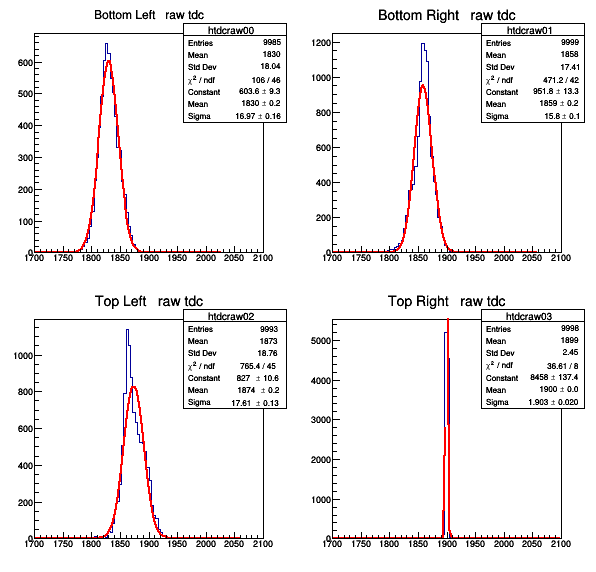

In [4]:
c1->Draw();

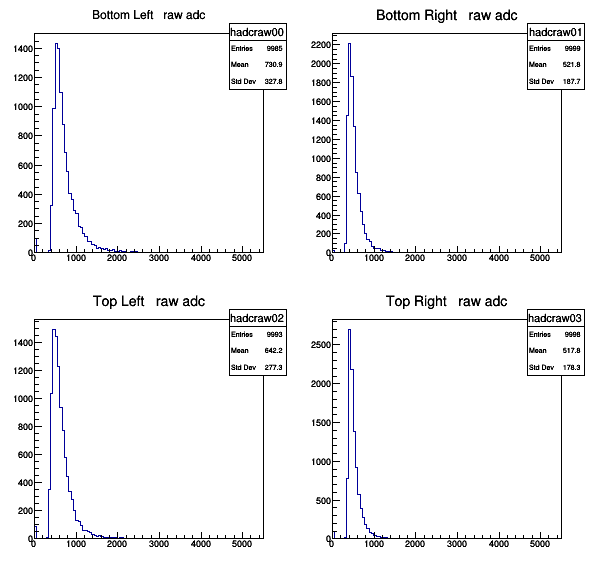

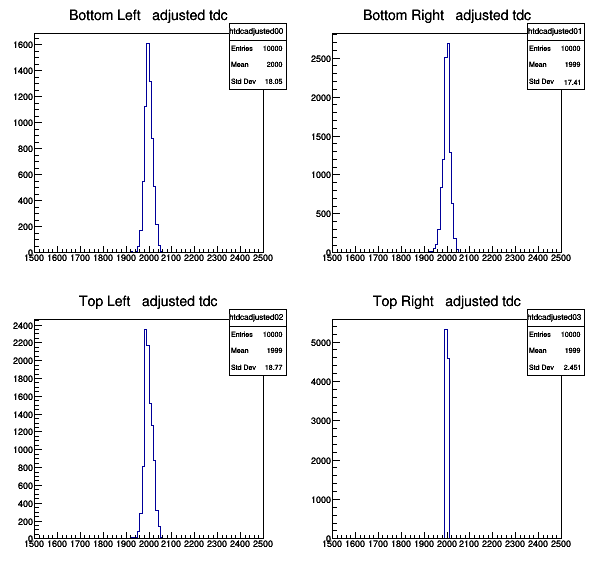

In [5]:
tdc_canvas->Draw();
tdca_canvas->Draw();

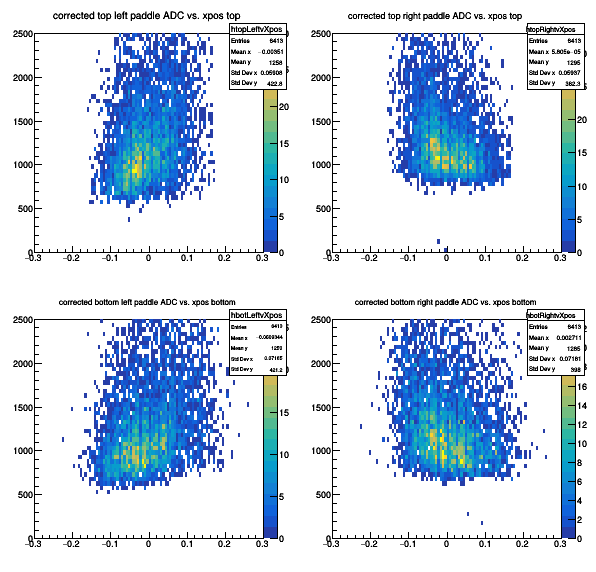

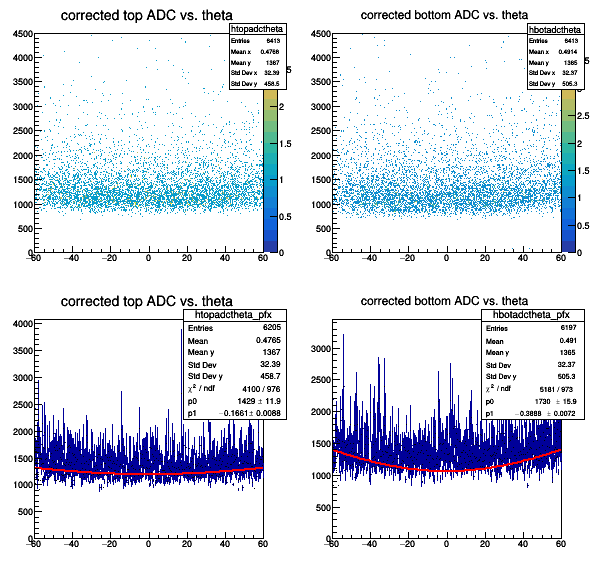

In [6]:
adcpos->Draw();
adctheta->Draw();


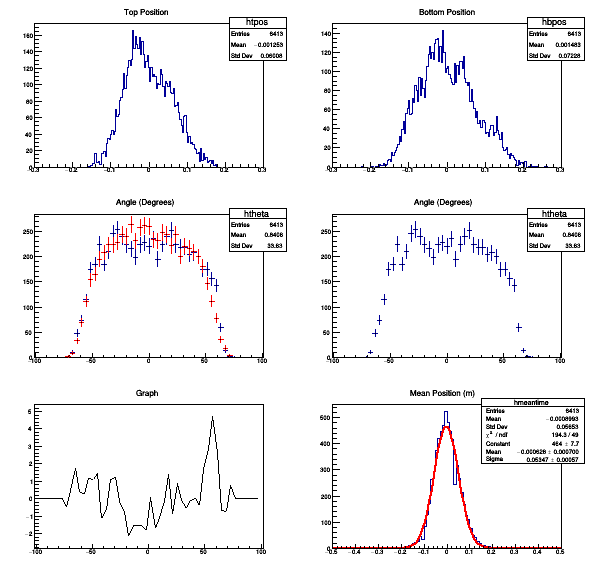

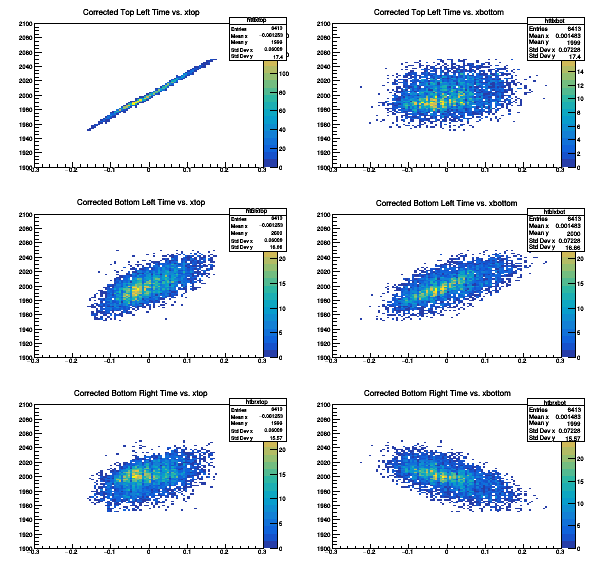

In [7]:
tdcpos->Draw();
tdcposcorr->Draw();


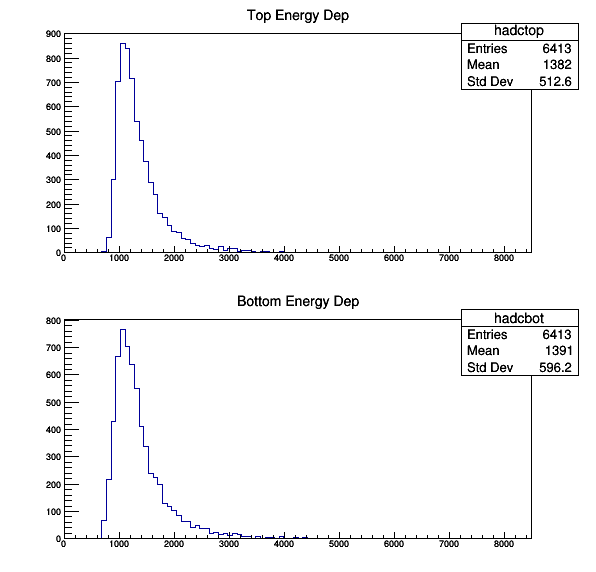

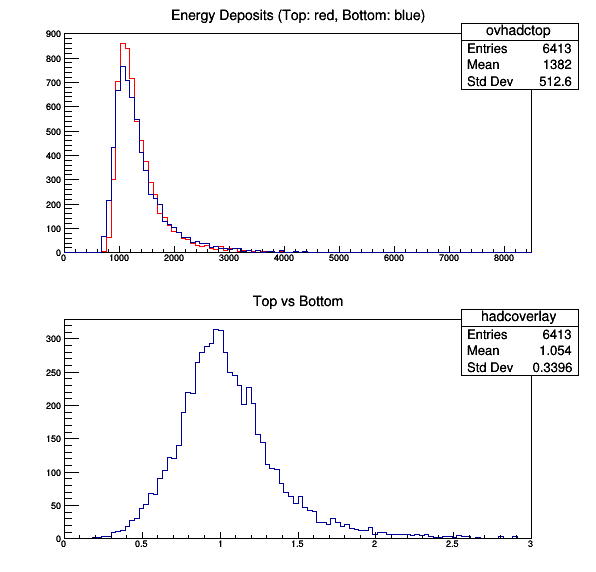

In [8]:
adctot->Draw();
adcoverlay->Draw()